In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

import lightgbm as lgb

from functions import all_models as m
from functions import plot_importances

import warnings
warnings.filterwarnings("ignore")

In [2]:
reddit = pd.read_csv('Data/reddit_data.csv', index_col=0)

In [3]:
reddit.head()

,author,body,created_utc,permalink,score,subreddit,total_awards_received,Polarity,Subjectivity,Sentiment,date,target
0,Flip2428,Growing up there I was always dumbfounded on h...,2021-04-01 17:17:58,/r/politics/comments/mhy1zm/new_mexico_is_set_...,1,politics,0,-0.051389,0.368056,Negative,4/1/2021,53.43079
1,boatpile,"Gaetz didn't even say ""no age you can't be sex...",2021-04-01 17:17:58,/r/politics/comments/mhuv7u/theres_no_age_that...,1,politics,0,0.412500,0.820833,Positive,4/1/2021,53.43079
2,theombudsmen,"I'm sure everyone knows this, but to clarify t...",2021-04-01 17:17:56,/r/politics/comments/mhzm4r/the_gop_rightly_fe...,1,politics,0,0.100000,0.853472,Positive,4/1/2021,53.43079
3,Tony_Chu,Hang up decorations with zip ties and cheer th...,2021-04-01 17:17:54,/r/politics/comments/mhulza/biden_must_clean_u...,1,politics,0,0.000000,0.000000,Neutral,4/1/2021,53.43079
4,Fellums2,"Aside from the fact that he is just awful, he ...",2021-04-01 17:17:53,/r/politics/comments/mhmik7/ap_poll_finds_bide...,1,politics,0,-0.284821,0.735714,Negative,4/1/2021,53.43079


In [4]:
reddit.drop(columns=['author', 'permalink', 'created_utc', 'Sentiment', 'date'], inplace=True)

In [5]:
stop_words = stopwords.words('english')

def process(text):
    
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    
    text = text.lower() #convert to lowercase
    text = tokenizer.tokenize(text) #tokenize
    text = [word for word in text if word not in stop_words] #remove stopwords
    text = [lemmatizer.lemmatize(word) for word in text] #lemmatize
    text = ' '.join(text) #convert list of words back to a string
    return text

In [6]:
x = reddit.drop(columns=['target'])
y = reddit['target']

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=16)

In [8]:
x_train_text = x_train['body'].apply(process)
x_test_text = x_test['body'].apply(process)

In [9]:
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern='[a-zA-Z0-9]+', max_features=1000)
x_train_text = vectorizer.fit_transform(x_train_text)
x_test_text = vectorizer.transform(x_test_text)

In [10]:
x_train_text_df = pd.DataFrame(x_train_text.todense(), columns = vectorizer.get_feature_names())
x_test_text_df = pd.DataFrame(x_test_text.todense(), columns = vectorizer.get_feature_names())

In [11]:
x_train.drop(columns=['body'], inplace=True)
x_train = pd.get_dummies(x_train)
x_train_text_df.set_index(x_train.index, inplace=True)
x_train = pd.concat([x_train, x_train_text_df], axis=1).reindex(x_train.index)

x_test.drop(columns=['body'], inplace=True)
x_test = pd.get_dummies(x_test)
x_test_text_df.set_index(x_test.index, inplace=True)
x_test = pd.concat([x_test, x_test_text_df], axis=1).reindex(x_test.index)

In [23]:
objects = [LinearRegression(), 
           Pipeline([('ss', StandardScaler(with_mean=False)), ('knn', KNeighborsRegressor())]),
           DecisionTreeRegressor(), 
           RandomForestRegressor(),
           XGBRegressor(),
           CatBoostRegressor(verbose=False),
          lgb.LGBMRegressor()]
index = ['Linear Regression', 'Nearest Neighbors', 'Decision Tree', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM']

In [13]:
models = m(x_train_text, x_test_text, y_train, y_test, objects=objects, index=index)

Logistic Regression model fit...
Nearest Neighbors model fit...
Decision Tree model fit...
Random Forest model fit...
XGBoost model fit...
CatBoost model fit...
LightGBM model fit...


,RMSE,R-Squared
Logistic Regression,215.99%,3.34%
Nearest Neighbors,236.02%,-15.42%
Decision Tree,282.19%,-65.00%
Random Forest,220.79%,-1.01%
XGBoost,215.32%,3.94%
CatBoost,214.79%,4.41%
LightGBM,214.83%,4.37%


In [24]:
rmse = [2.1599, 2.3602, 2.8219, 2.2079, 2.1532, 2.1479, 2.1483]
rsquared = [.0334, -.1542, -.65, -.0101, .0394, .0441, .0437]

metrics = pd.DataFrame(np.array([rmse, rsquared]).T, index = index, columns = ['RMSE', 'R-Squared'])
display(metrics)

,RMSE,R-Squared
Linear Regression,2.1599,0.0334
Nearest Neighbors,2.3602,-0.1542
Decision Tree,2.8219,-0.6500
Random Forest,2.2079,-0.0101
XGBoost,2.1532,0.0394
CatBoost,2.1479,0.0441
LightGBM,2.1483,0.0437


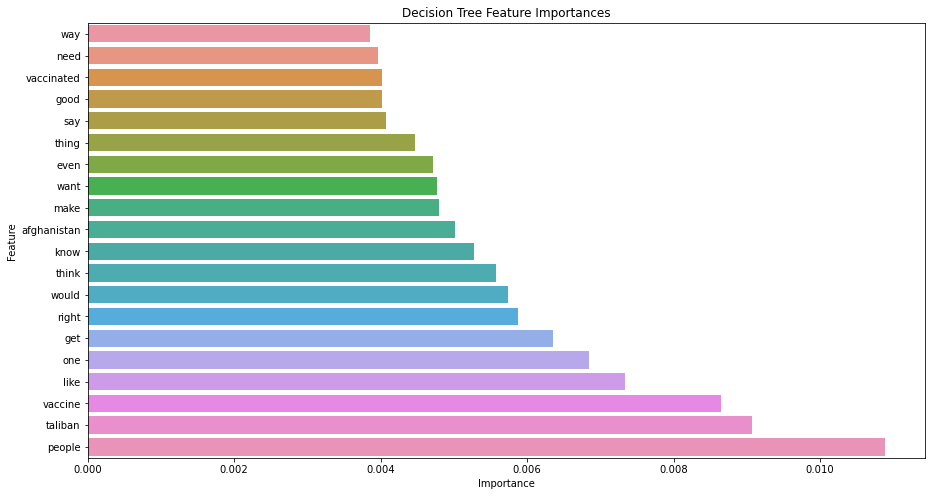

In [27]:
importances = sorted(list(zip(models[2].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title('Decision Tree Feature Importances')
plt.show();

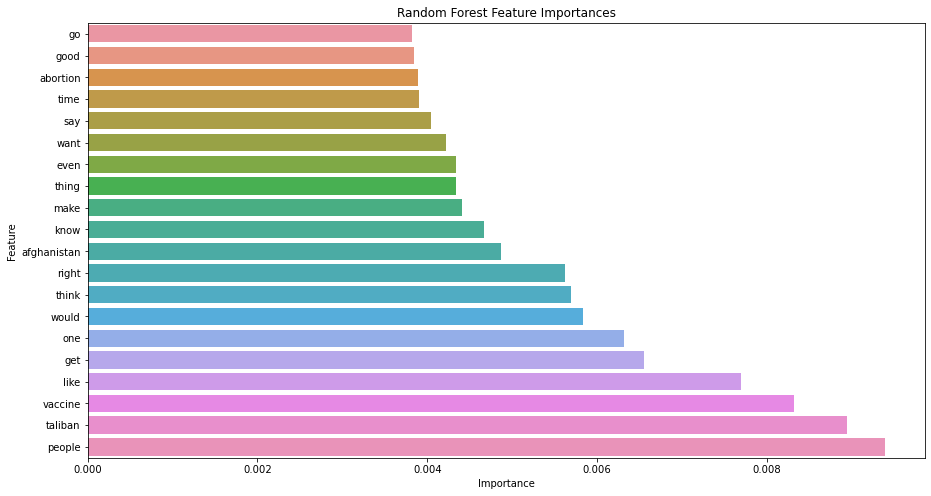

In [28]:
importances = sorted(list(zip(models[3].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title('Random Forest Feature Importances')
plt.show();

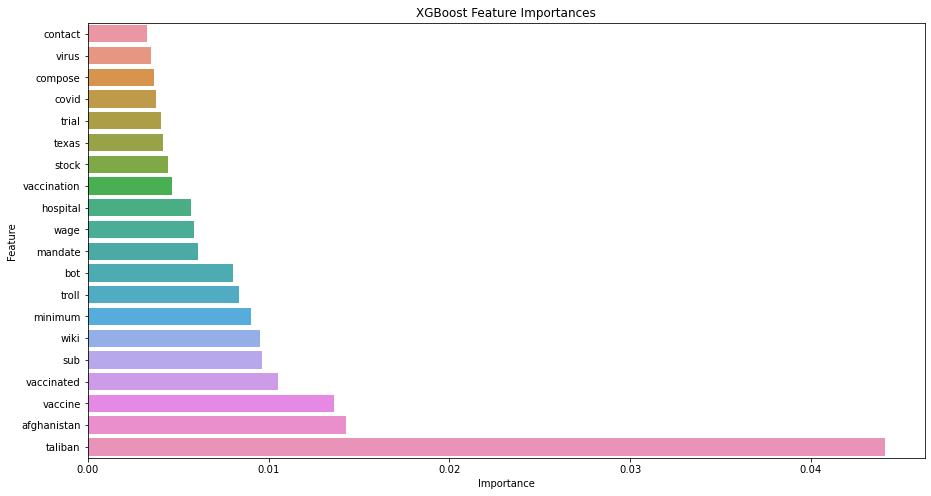

In [29]:
importances = sorted(list(zip(models[4].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title('XGBoost Feature Importances')
plt.show();

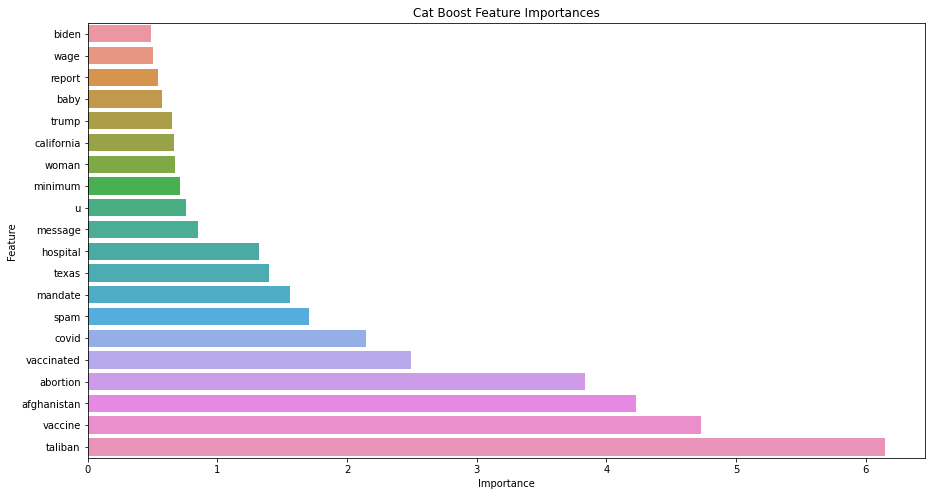

In [30]:
importances = sorted(list(zip(models[5].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title('Cat Boost Feature Importances')
plt.show();

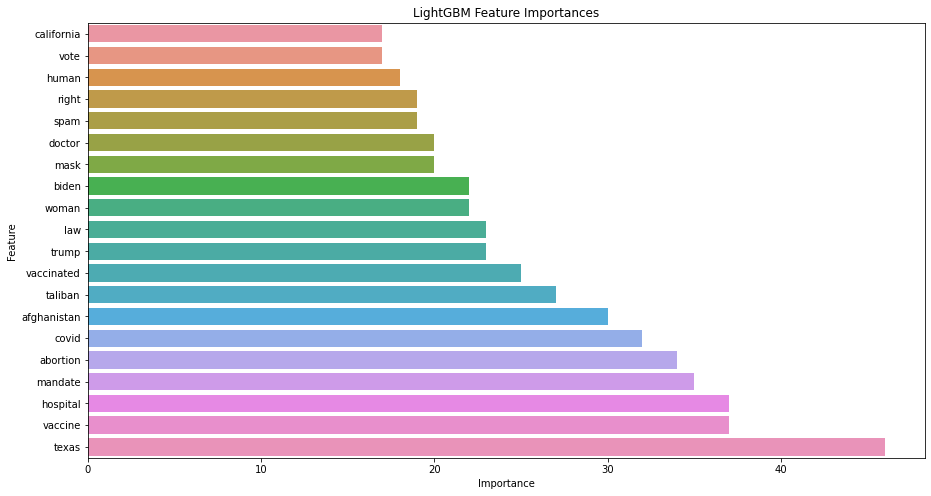

In [31]:
importances = sorted(list(zip(models[6].feature_importances_, vectorizer.get_feature_names())))[-20:]
plot = pd.DataFrame(importances, columns=['Importance', 'Feature'])

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=plot, y='Feature', x='Importance')
ax.set_title('LightGBM Feature Importances')
plt.show();